In [ ]:
#!pip install transformers
!pip install pycorenlp
!pip install pyneuroner[gpu]
!python -m spacy download es

In [1]:
# -*- coding: utf-8 -*-
#source code available at https://github.com/juand-r/entity-recognition-datasets/tree/master/data/i2b2_2014
#another source : https://github.com/Franck-Dernoncourt/NeuroNER
import codecs
import glob
import json
import os

from pycorenlp import StanfordCoreNLP
import spacy

from neuroner import utils_nlp


def get_start_and_end_offset_of_token_from_spacy(token):
    start = token.idx
    end = start + len(token)
    return start, end

def get_sentences_and_tokens_from_spacy(text, spacy_nlp):
    document = spacy_nlp(text)
    # sentences
    sentences = []
    for span in document.sents:
        sentence = [document[i] for i in range(span.start, span.end)]
        sentence_tokens = []
        for token in sentence:
            token_dict = {}
            token_dict['start'], token_dict['end'] = get_start_and_end_offset_of_token_from_spacy(token)
            token_dict['text'] = text[token_dict['start']:token_dict['end']]
            if token_dict['text'].strip() in ['\n', '\t', ' ', '']:
                continue
            # Make sure that the token text does not contain any space
            if len(token_dict['text'].split(' ')) != 1:
                print("WARNING: the text of the token contains space character, replaced with hyphen\n\t{0}\n\t{1}".format(token_dict['text'], 
                                                                                                                           token_dict['text'].replace(' ', '-')))
                token_dict['text'] = token_dict['text'].replace(' ', '-')
            sentence_tokens.append(token_dict)
        sentences.append(sentence_tokens)
    return sentences

def get_stanford_annotations(text, core_nlp, port=9000, annotators='tokenize,ssplit,pos,lemma'):
    output = core_nlp.annotate(text, properties={
        "timeout": "10000",
        "ssplit.newlineIsSentenceBreak": "two",
        'annotators': annotators,
        'outputFormat': 'json'
    })
    if type(output) is str:
        output = json.loads(output, strict=False)
    return output

def get_sentences_and_tokens_from_stanford(text, core_nlp):
    stanford_output = get_stanford_annotations(text, core_nlp)
    sentences = []
    for sentence in stanford_output['sentences']:
        tokens = []
        for token in sentence['tokens']:
            token['start'] = int(token['characterOffsetBegin'])
            token['end'] = int(token['characterOffsetEnd'])
            token['text'] = text[token['start']:token['end']]
            if token['text'].strip() in ['\n', '\t', ' ', '']:
                continue
            # Make sure that the token text does not contain any space
            if len(token['text'].split(' ')) != 1:
                print("WARNING: the text of the token contains space character, replaced with hyphen\n\t{0}\n\t{1}".format(token['text'], 
                                                                                                                           token['text'].replace(' ', '-')))
                token['text'] = token['text'].replace(' ', '-')
            tokens.append(token)
        sentences.append(tokens)
    return sentences

def get_entities_from_brat(text_filepath, annotation_filepath, verbose=False):
    # load text
    with codecs.open(text_filepath, 'r', 'UTF-8') as f:
        text =f.read()
    if verbose: print("\ntext:\n{0}\n".format(text))

    # parse annotation file
    entities = []
    with codecs.open(annotation_filepath, 'r', 'UTF-8') as f:
        for line in f.read().splitlines():
            anno = line.split()
            id_anno = anno[0]
            # parse entity
            if id_anno[0] == 'T':
                entity = {}
                entity['id'] = id_anno
                entity['type'] = anno[1]
                entity['start'] = int(anno[2])
                entity['end'] = int(anno[3])
                entity['text'] = ' '.join(anno[4:])
                if verbose:
                    print("entity: {0}".format(entity))
                # Check compatibility between brat text and anootation
                if utils_nlp.replace_unicode_whitespaces_with_ascii_whitespace(text[entity['start']:entity['end']]) != \
                    utils_nlp.replace_unicode_whitespaces_with_ascii_whitespace(entity['text']):
                    print("Warning: brat text and annotation do not match.")
                    print("\ttext: {0}".format(text[entity['start']:entity['end']]))
                    print("\tanno: {0}".format(entity['text']))
                # add to entitys data
                entities.append(entity)
    if verbose: print("\n\n")
    
    return text, entities

def check_brat_annotation_and_text_compatibility(brat_folder):
    '''
    Check if brat annotation and text files are compatible.
    '''
    dataset_type =  os.path.basename(brat_folder)
    print("Checking the validity of BRAT-formatted {0} set... ".format(dataset_type), end='')
    text_filepaths = sorted(glob.glob(os.path.join(brat_folder, '*.txt')))
    for text_filepath in text_filepaths:
        base_filename = os.path.splitext(os.path.basename(text_filepath))[0]
        annotation_filepath = os.path.join(os.path.dirname(text_filepath), base_filename + '.ann')
        # check if annotation file exists
        if not os.path.exists(annotation_filepath):
            raise IOError("Annotation file does not exist: {0}".format(annotation_filepath))
        text, entities = get_entities_from_brat(text_filepath, annotation_filepath)
    print("Done.")

def brat_to_conll(input_folder, output_filepath, tokenizer, language):
    '''
    Assumes '.txt' and '.ann' files are in the input_folder.
    Checks for the compatibility between .txt and .ann at the same time.
    '''
    if tokenizer == 'spacy':
        spacy_nlp = spacy.load(language)
    elif tokenizer == 'stanford':
        core_nlp = StanfordCoreNLP('http://localhost:{0}'.format(9000))
    else:
        raise ValueError("tokenizer should be either 'spacy' or 'stanford'.")
    verbose = False
    dataset_type =  os.path.basename(input_folder)
    print("Formatting {0} set from BRAT to CONLL... ".format(dataset_type), end='')
    text_filepaths = sorted(glob.glob(os.path.join(input_folder, '*.txt')))
    output_file = codecs.open(output_filepath, 'w', 'utf-8')
    for text_filepath in text_filepaths:
        base_filename = os.path.splitext(os.path.basename(text_filepath))[0]
        annotation_filepath = os.path.join(os.path.dirname(text_filepath), base_filename + '.ann')
        # create annotation file if it does not exist
        if not os.path.exists(annotation_filepath):
            codecs.open(annotation_filepath, 'w', 'UTF-8').close()

        text, entities = get_entities_from_brat(text_filepath, annotation_filepath)
        entities = sorted(entities, key=lambda entity:entity["start"])
        
        if tokenizer == 'spacy':
            sentences = get_sentences_and_tokens_from_spacy(text, spacy_nlp)
        elif tokenizer == 'stanford':
            sentences = get_sentences_and_tokens_from_stanford(text, core_nlp)
        
        for sentence in sentences:
            inside = False
            previous_token_label = 'O'
            for token in sentence:
                token['label'] = 'O'
                for entity in entities:
                    if entity['start'] <= token['start'] < entity['end'] or \
                       entity['start'] < token['end'] <= entity['end'] or \
                       token['start'] < entity['start'] < entity['end'] < token['end']:

                        token['label'] = entity['type'].replace('-', '_') # Because the ANN doesn't support tag with '-' in it

                        break
                    elif token['end'] < entity['start']:
                        break
                        
                if len(entities) == 0:
                    entity={'end':0}
                if token['label'] == 'O':
                    gold_label = 'O'
                    inside = False
                elif inside and token['label'] == previous_token_label:
                    gold_label = 'I-{0}'.format(token['label'])
                else:
                    inside = True
                    gold_label = 'B-{0}'.format(token['label'])
                if token['end'] == entity['end']:
                    inside = False
                previous_token_label = token['label']
                if verbose: print('{0} {1} {2} {3} {4}\n'.format(token['text'], base_filename, token['start'], token['end'], gold_label))
                output_file.write('{0} {1} {2} {3} {4}\n'.format(token['text'], base_filename, token['start'], token['end'], gold_label))
            if verbose: print('\n')
            output_file.write('\n')

    output_file.close()
    print('Done.')
    if tokenizer == 'spacy':
        del spacy_nlp
    elif tokenizer == 'stanford':
        del core_nlp

In [2]:
brat_to_conll('../input/oldmedoprof/experiments/test', './test.txt', 'spacy', 'es')
brat_to_conll('../input/full-meddoprof-ds/meddoprof-training-set/task1', './train.txt', 'spacy', 'es')

Formatting test set from BRAT to CONLL... Done.
Formatting task1 set from BRAT to CONLL... Done.


In [3]:
import pandas as pd
test=pd.read_csv('./test.txt',sep=' ',names=['words','fileId','start','end','label'],quoting=3, error_bad_lines=False)
test.head()

,words,fileId,start,end,label
0,Nombre,S0034-98872006000200012-1,0,6,O
1,:,S0034-98872006000200012-1,6,7,O
2,Gabriel,S0034-98872006000200012-1,8,15,O
3,.,S0034-98872006000200012-1,16,17,O
4,Apellidos,S0034-98872006000200012-1,18,27,O


In [4]:
import pandas as pd
train=pd.read_csv('./train.txt',sep=' ',names=['words','fileId','start','end','label'],quoting=3, error_bad_lines=False)
train.head()

,words,fileId,start,end,label
0,Un,32247016_ES,0,2,O
1,paciente,32247016_ES,3,11,O
2,de,32247016_ES,12,14,O
3,unos,32247016_ES,15,19,O
4,cincuenta,32247016_ES,20,29,O


In [5]:
class ProcessSentences(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["words"].values.tolist(),
                                                           s["label"].values.tolist())]
        self.grouped = self.data.groupby("fileId").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [6]:
sentences_data_train = ProcessSentences(train)
sentences_data_dev = ProcessSentences(test)
sentences_data_test = ProcessSentences(test)

sentences_train = [[word[0] for word in sentence] for sentence in sentences_data_train.sentences]
sentences_dev = [[word[0] for word in sentence] for sentence in sentences_data_dev.sentences]
sentences_test = [[word[0] for word in sentence] for sentence in sentences_data_test.sentences]
print(sentences_dev[0][50:100]) # First 10 elements of sentence 1

# Show labels
labels_train = [[s[1] for s in sentence] for sentence in sentences_data_train.sentences]
labels_dev = [[s[1] for s in sentence] for sentence in sentences_data_dev.sentences]
labels_test = [[s[1] for s in sentence] for sentence in sentences_data_test.sentences]
print(labels_dev[0][50:100]) # First 10 labels of sentence 1

[':', '39', 'años', 'Sexo', ':', 'H.', 'Fecha', 'de', 'Ingreso', ':', '21/12/2017', '.', 'Médico', ':', 'Itziar', 'Palacios', 'Zabalza', 'NºCol', ':', '50', '50', '11945', '.', 'Hombre', 'de', '28', 'años', ',', 'soldado', '.', 'Al', 'reiniciar', 'su', 'entrenamiento', 'físico', 'con', 'la', 'intención', 'de', 'participar', 'en', 'una', 'triatlón', ',', 'después', 'de', 'haber', 'estado', '2', 'meses']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PROFESION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PROFESION', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [7]:

# Label values
tag_values = list(set(train["label"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}


In [8]:
## Prepare data for BERT
# Import pytorch and transformers library
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import transformers
from transformers import BertTokenizer, BertConfig

from keras.preprocessing.sequence import pad_sequences

torch.__version__


# Define BERT parameters
# Sentence length
MAX_LEN = 510
# Batch size
bs = 8

In [9]:
# CUDA device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)
# Print state of GPU
!nvidia-smi

Sun Jun  6 12:51:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
# Import BERT tokenizer
# Use the BETO model (BERT for Spanish), available in the Transformers library  
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/242k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/134 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/364 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/480k [00:00<?, ?B/s]

In [11]:
# Function to tokenize and preserve labels
def tokenize_and_keep_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize each word and count number of its subwords
        # We force conversion to string to avoid errors with float elements
        tokenized_word = tokenizer.tokenize(str(word))
        n_subwords = len(tokenized_word)

        # The tokenized word is added to the resulting tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # The same label is added to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels


tokenized_texts_and_labels_train = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_train, labels_train)
]

tokenized_texts_and_labels_dev = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_dev, labels_dev)
]

tokenized_texts_and_labels_test = [
    tokenize_and_keep_labels(sent, labs)
    for sent, labs in zip(sentences_test, labels_test)
]



tokenized_texts_train = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_train]
labels_train = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_train]

tokenized_texts_dev = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_dev]
labels_dev = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_dev]

tokenized_texts_test = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels_test]
labels_test = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels_test]



# Padding of sentences according to desired input length
input_ids_train = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_train],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_dev = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_dev],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

input_ids_test = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts_test],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


# Paddding of labels with regard to input length
tags_train = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_train],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_dev = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_dev],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

tags_test = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels_test],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")



# Create the attention mask to ignore the padded elements in the sequences during training, development and testing
attention_masks_train = [[float(i != 0.0) for i in ii] for ii in input_ids_train]
attention_masks_dev = [[float(i != 0.0) for i in ii] for ii in input_ids_dev]
attention_masks_test = [[float(i != 0.0) for i in ii] for ii in input_ids_test]

In [12]:
# Convert the dataset to torch tensors
train_inputs = torch.tensor(input_ids_train)
dev_inputs = torch.tensor(input_ids_dev)
test_inputs = torch.tensor(input_ids_test)
train_tags = torch.tensor(tags_train)
dev_tags = torch.tensor(tags_dev)
test_tags = torch.tensor(tags_test)
train_masks = torch.tensor(attention_masks_train)
dev_masks = torch.tensor(attention_masks_dev)
test_masks = torch.tensor(attention_masks_test)


# We define the dataloaders. 
# Shuffle the data for training using RandomSampler
train_data = TensorDataset(train_inputs, train_masks, train_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

# Load dev and test data sequentially with SequentialSampler.
dev_data = TensorDataset(dev_inputs, dev_masks, dev_tags)
dev_sampler = SequentialSampler(dev_data)
dev_dataloader = DataLoader(dev_data, sampler=dev_sampler, batch_size=bs)

test_data = TensorDataset(test_inputs, test_masks, test_tags)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=bs)

In [13]:
# The BertForTokenClassification class is used for token-level predictions. 
# It includes the BERT model and carries out token-level classification in the last layer
# We use the Adam optimizer
from transformers import BertForTokenClassification, AdamW

# Instantiate the model and use the pretrained BETO model (BERT for Spanish)
model = BertForTokenClassification.from_pretrained(
    "dccuchile/bert-base-spanish-wwm-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

# Load the model to the GPU
model.cuda();

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at dccuchile/bert-base-spanish-wwm-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at dccuchile/bert-base

In [14]:
# weight_decay is a regularization procedure with regard to the weight matrices
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

# Adam optimizer
optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [15]:
# Import a scheduler to reduce the learning rate 
from transformers import get_linear_schedule_with_warmup

# Number of training epochs; the BERT paper uses 4
epochs = 50
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [16]:
# Import modules to measure the progression of training
# Done
!pip install seqeval

import seqeval
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report


     |████████████████████████████████| 43 kB 259 kB/s eta 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=ed3c670417769e46b6d17e8962fc159a4b7541c14f9a154172733b4fd97c487e
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


In [17]:
%%time 
# To measure execution time of this cell

# Train the model for; the BERT paper uses 4
## Store the average loss after each epoch; these values are used to plot the loss.
loss_values, development_loss_values = [], []

for _ in range(epochs):
    #
    # Training
    #
    # Set the model into training mode
    model.train()
    # Reset the total loss for each epoch
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        # Transfer batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Remove previous gradients before each backward pass
        model.zero_grad()
        # forward pass
        # This returns the loss (not the model output) since we have input the labels.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # Get the loss
        loss = outputs[0]
        # Backward pass to compute the gradients
        loss.backward()
        # Train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # Update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))
    

    # Store each loss value for plotting the learning curve afterwards
    loss_values.append(avg_train_loss)

    # After each training epoch, measure performance on development set

    # Set the model into evaluation mode
    model.eval()
    # Reset the development loss for this epoch
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in dev_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # The model must not compute or save gradients, in order to save memory and speed up this step
        with torch.no_grad():
            # Forward pass, compute predictions
            # This will return the logits (logarithm of the odds), not the loss (we do not provide labels)
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Transfer logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Compute the accuracy for this batch of development sentences
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(dev_dataloader)
    development_loss_values.append(eval_loss)
    print("Development loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    dev_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Development Accuracy: {}".format(accuracy_score(dev_tags,pred_tags)))
    print("Micro F1 score: {}".format(f1_score(dev_tags,pred_tags,average='micro')))

    print("Development classification report:\n{}".format(classification_report (dev_tags,pred_tags,digits=4)))
    print()

Average train loss: 0.06453477819276815
Development loss: 0.006324345584289404
Development Accuracy: 0.998163302120402
Micro F1 score: 0.998163302120402


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Development classification report:
                     precision    recall  f1-score   support

        B-ACTIVIDAD     0.0000    0.0000    0.0000         5
        B-PROFESION     0.8889    0.9479    0.9174       422
B-SITUACION_LABORAL     0.9753    0.6124    0.7524       129
        I-ACTIVIDAD     0.0000    0.0000    0.0000        14
        I-PROFESION     0.8741    0.9782    0.9232       504
I-SITUACION_LABORAL     0.7750    0.3875    0.5167        80
                  O     0.9992    0.9994    0.9993    120804

           accuracy                         0.9982    121958
          macro avg     0.6446    0.5608    0.5870    121958
       weighted avg     0.9980    0.9982    0.9980    121958


Average train loss: 0.013767418797447426
Development loss: 0.002158610554488405
Development Accuracy: 0.9994752291772577
Micro F1 score: 0.9994752291772577
Development classification report:
                     precision    recall  f1-score   support

        B-ACTIVIDAD     0.3333    0.2

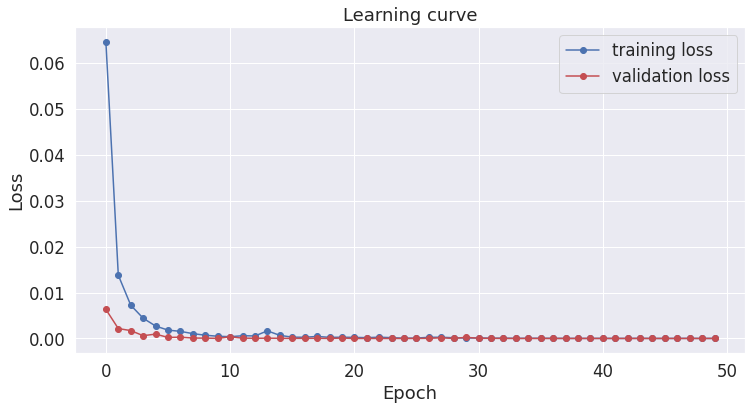

In [18]:
# Plot the training loss
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(development_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [19]:
def tagger(test_sentence):
  tokenized_sentence = tokenizer.encode(test_sentence,max_length=MAX_LEN,truncation=True)
  
  input_ids = torch.tensor([tokenized_sentence]).cuda()
  with torch.no_grad():
      output = model(input_ids)
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)

  # join bpe split tokens
  tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
  new_tokens, new_labels = [], []
  for token, label_idx in zip(tokens, label_indices[0]):
      if token.startswith("##"):
          new_tokens[-1] = new_tokens[-1] + token[2:]
      else:
          new_labels.append(tag_values[label_idx])
          new_tokens.append(token)
  return new_tokens,new_labels

  #for token, label in zip(new_tokens, new_labels):
  #    print("{}\t{}".format(label, token))

In [23]:
!mkdir ./out
def format(path):
  file=open(path).read()
  t,l=tagger(file)
  fname=str(path).split('/')[-1][:-4]
  ann=open("./out/"+fname+".ann", "w")
  t,l=tagger(file)
  for i in range(len(t)):
    if l[i]!='O':
      if l[i].startswith('B-'):
        if l[i+1]=='O':
          ann.write('T'+str(i)+'\t'+l[i][2:]+' '+str(file.find(t[i]))+' '+str(file.find(t[i])+len(t[i]))+'\t'+t[i]+'\n')
        else:
          j=i+1
          tmp=t[i]
          while l[j] !='O':
            tmp=tmp+' '+t[j]
            j=j+1
          ann.write('T'+str(j)+'\t'+l[i][2:]+' '+str(file.find(tmp.strip()))+' '+str(file.find(tmp.strip())+len(tmp.strip()))+'\t'+tmp.strip()+'\n')


In [24]:
import os
from pathlib import Path
path=Path('../input/full-meddoprof-ds/meddoprof_test_txt/meddoprof_test_txt')

In [25]:

for user in os.listdir(path):
            if str(user)[-1]=='n' : 
                continue
            print("\t\t Working on text: ", user )
            format(os.path.join(path, user))
            

		 Working on text:  casos_clinicos_profesiones181.txt
		 Working on text:  caso_clinico_psiquiatria438.txt
		 Working on text:  casos_clinicos_profesiones113.txt
		 Working on text:  cc_onco884.txt
		 Working on text:  casos_clinicos_profesiones134.txt
		 Working on text:  caso_clinico_dermatologia456.txt
		 Working on text:  casos_clinicos_profesiones222.txt
		 Working on text:  cc_onco1574.txt
		 Working on text:  caso_clinico_psiquiatria471.txt
		 Working on text:  casos_clinicos_profesiones145.txt
		 Working on text:  casos_clinicos_profesiones141.txt
		 Working on text:  caso_clinico_medicina_interna407.txt
		 Working on text:  casos_clinicos_profesiones167.txt
		 Working on text:  caso_clinico_endocrinologia47.txt
		 Working on text:  caso_clinico_psiquiatria22.txt
		 Working on text:  casos_clinicos_profesiones138.txt
		 Working on text:  casos_clinicos_profesiones232.txt
		 Working on text:  caso_clinico_psiquiatria69.txt
		 Working on text:  caso_clinico_psiquiatria360.txt
		

In [26]:
!zip -r ./bert_meddoprof_submission.zip ./out

  adding: out/ (stored 0%)
  adding: out/cc_onco145.ann (stored 0%)
  adding: out/caso_clinico_neurologia195.ann (stored 0%)
  adding: out/cc_covid45.ann (stored 0%)
  adding: out/casos_clinicos_profesiones180.ann (stored 0%)
  adding: out/casos_clinicos_profesiones226.ann (deflated 1%)
  adding: out/caso_clinico_psiquiatria226.ann (stored 0%)
  adding: out/caso_clinico_psiquiatria136.ann (stored 0%)
  adding: out/caso_clinico_endocrinologia149.ann (stored 0%)
  adding: out/casos_clinicos_profesiones229.ann (deflated 8%)
  adding: out/casos_clinicos_profesiones199.ann (deflated 41%)
  adding: out/casos_clinicos_profesiones228.ann (deflated 46%)
  adding: out/casos_clinicos_profesiones183.ann (deflated 16%)
  adding: out/casos_clinicos_profesiones222.ann (deflated 42%)
  adding: out/casos_clinicos_profesiones121.ann (stored 0%)
  adding: out/cc_onco1559.ann (stored 0%)
  adding: out/casos_clinicos_profesiones165.ann (deflated 37%)
  adding: out/casos_clinicos_profesiones119.ann (deflate

In [ ]:
!zip -r ./bert_meddoprof.zip ./resources/taggers/ner-spanish-large